# 2. Base de Dados da Aesa

```python
Esse caderno tem como objetivo a obtenção de precipitações acumuladas 
mensais para os dados locais.
```

In [1]:
import os
import numpy as np
import pandas as pd
import contextily as ctx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator

## 2.1. Configurações

In [2]:
# Definição de se vai gerar ou abrir o CSV
generate_csv_sum = False
generate_csv_max = False

# Definição de base de dados original
df_aesa = pd.read_csv('../datas/raw/2_aesa_data/aesa_1994-2023_day.csv')

# Redefinindo nomes das colunas

df_aesa = df_aesa.rename(
    columns={
        'Altitude': 'alt',
        'Bacia': 'bac',
        'Latitude': 'lat',
        'Longitude': 'lon',
        'Ano': 'ano',
        'Mês': 'mes',
    }
)

# Substituindo vírgulas por pontos e convertendo para float
for coluna in ['alt', 'lat', 'lon', 'Total']:
    df_aesa[coluna] = df_aesa[coluna].str.replace(',', '.').astype(float)

## 2.2. Funções

### 2.1.1. Função para Criar Serie Temporal Completa

In [3]:
def complete_temporal_series(df: pd.DataFrame,
                             lat_col: str,
                             lon_col: str,
                             alt_col: str,
                             bac_col: str,
                             anos: list) -> pd.DataFrame:
    '''
    Cria séries temporais com frequência mensal para localizações e anos definidos
    '''
    
    # Obtendo pontos de lat lon únicos
    df_pontos_unicos = df[[lat_col, lon_col, alt_col, bac_col]].drop_duplicates().reset_index().drop(columns=["index"])

    # Obtendo meses e anos da base de dados
    df_anos_meses = pd.DataFrame([(ano, mes) for ano in anos for mes in range(1, 13)], columns=["ano", "mes"])

    # Fazendo produto cartesiano entre pontos e anos/meses
    df_pontos_unicos['key'] = 1
    df_anos_meses['key'] = 1

    # Unindo pontos e anos/meses
    df_expandido = pd.merge(df_pontos_unicos, df_anos_meses, on='key').drop(columns='key')

    # Cria um DataFrame vazio para armazenar os dados expandidos
    return df_expandido

### 2.1.2. Função para Limeza de Terminal e Células

In [4]:
def clear():
    '''
    Função para limpar terminal ou célula
    '''

    # Limpando terminal
    os.system('cls')

    # Limpando célula
    clear_output(wait=True)

### 2.1.3. Função para Interpolação por IDW

In [5]:
def porcentagem_em_barra(valor_atual: int, 
                         valor_total: int) -> str:
    """
    Gerador de barra de porcentagem a partir de valor atual e total.
    """
    
    porcentagem = 100 * (valor_atual / valor_total)

    completo   = '-' * (int(porcentagem))
    incompleto = '_' * (100 - int(porcentagem))

    situacao = f'[{completo}{incompleto}] {porcentagem:.2f}% ({valor_atual} de {valor_total})'

    return situacao

def vizinhos_proximos(lat: float,
                      lon: float,
                      lat_lon: list[str],
                      n_vizinhos: int = 5) -> list:
    """
    Gerador de lista de pontos vizinhos próximos de determinado ponto.

    Args:
        lat (float): Latitude do ponto principal;
        lon (float): Logitude do ponto principal;
        lat_lon (list[str]): Lista com latitudes e longitudes de pontos próximos ao ponto principal;
        n_vizinhos (int, optional): Números de pontos vizinhos ao ponto principal a se estimar.

    Returns:
        list: Lista de n pontos mais próximos ao ponto principal.
    """
    
    # Lista para armazenar tuplas (string_original, distancia)
    distancias = []

    for ponto_str in lat_lon:
        lat_p, lon_p = map(float, ponto_str.split(";"))
        dist = np.linalg.norm(np.array([lat, lon]) - np.array([lat_p, lon_p]))
        distancias.append((ponto_str, dist))
    
    # Ordena pela menor distância
    distancias_ordenadas = sorted(distancias, key=lambda x: x[1])
    
    # Pega os n vizinhos mais próximos (ignorando o primeiro se for o próprio ponto)
    vizinhos = [p[0] for p in distancias_ordenadas if p[1] != 0][:n_vizinhos]
    
    return vizinhos

def interpolacao_por_idw(df: pd.DataFrame,
                         var_de_interpolacao: str,
                         var_de_predicao: str,
                         var_de_latitude: str,
                         var_de_longitude: str,
                         var_de_anos: str,
                         var_de_meses: str,
                         var_de_pontos: str,
                         n_vizinhos: int = 5,
                         constante: int = 2,) -> list:
    '''
    Interpola dados de séries temporais a partir do método IDW
    '''

    df[var_de_pontos] = df[var_de_latitude].astype(str) + ";" + df[var_de_longitude].astype(str)

    df_nao_nulos = df[df[var_de_predicao].notna()]

    df_nulos = df[df[var_de_predicao].isna()]

    nulo, nulos = 1, len(df_nulos)
    
    for i, linha in df_nulos.iterrows():

        # Ponto em cálculo
        print(porcentagem_em_barra(nulo, nulos))

        if pd.isna(linha[var_de_predicao]):

            lat = linha[var_de_latitude]
            lon = linha[var_de_longitude]
            ano = linha[var_de_anos]
            mes = linha[var_de_meses]

            # Filtrando pontos unicos que possuem mesmo mes e ano que o ponto em varredura
            pontos_unicos_filtrados = df_nao_nulos[(df_nao_nulos[var_de_anos ] == ano) &
                                                   (df_nao_nulos[var_de_meses] == mes)][var_de_pontos].unique()

            # Obtendo pontos vizinhos mais próximos do ponto em varredura
            vizinhos = vizinhos_proximos(lat, lon, pontos_unicos_filtrados, n_vizinhos)

            # Definindo variáveis para calcular IDW                
            dividendo = divisor = 0

            for ponto_vizinho in vizinhos:

                lat_vizinha, lon_vizinha = map(float, ponto_vizinho.split(";"))
                
                distancia = ((lat - lat_vizinha)**2 + (lon - lon_vizinha)**2)**(1/2)

                variavel = df_nao_nulos.loc[(df_nao_nulos[var_de_pontos] == ponto_vizinho) & 
                                            (df_nao_nulos[var_de_anos] == ano) & 
                                            (df_nao_nulos[var_de_meses] == mes), var_de_interpolacao]
                
                if not variavel.empty:
                    valor = variavel.iloc[0]
                else:
                    continue

                dividendo += valor / (distancia**constante)

                divisor += 1 / (distancia**constante)
            
            if divisor == 0:
                df_nulos.at[i, var_de_predicao] = np.nan
            else:
                df_nulos.at[i, var_de_predicao] = dividendo / divisor

        nulo += 1
        
        clear()

    df_nulos[var_de_predicao] = df[var_de_predicao].fillna(df[var_de_predicao].mean())

    return pd.concat([df_nao_nulos, df_nulos], ignore_index=True).copy()

### 2.1.4. Função para gerar gráfico de pontos para Paraíba

In [6]:
def grafico_de_pontos(df: pd.DataFrame,
                      latitude: str,
                      longitude: str):
    '''
    Função gera gráfico de pontos para região da Paraíba a partir de DataFrame
    '''
    
    # Exemplo de dados de precipitação
    latitudes = df[latitude].values
    longitudes = df[longitude].values

    # Criar o gráfico com Cartopy
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.Mercator()})
    ax.set_extent([-38.8, -34.7, -8.3, -6], crs=ccrs.PlateCarree())  # Definir a extensão de latitude e longitude

    # Adicionar o mapa base
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    # Desenhar as bordas do mapa
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linestyle='-', linewidth=0.5)

    # Desenhar paralelos e meridianos, ajustando a frequência dos labels
    gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
    gridlines.xlocator = MaxNLocator(integer=True, prune='lower', nbins=4)  # Limitar o número de labels para longitude
    gridlines.ylocator = MaxNLocator(integer=True, prune='lower', nbins=4)  # Limitar o número de labels para latitude

    # Criar o scatter plot com pontos azuis
    ax.scatter(longitudes, latitudes, color='blue', s=3, marker='o', transform=ccrs.PlateCarree())

    # Adicionar título e rótulos
    plt.title('Estado da Paraíba')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Mostrar o mapa
    plt.show()

## 2.3. Geração de base de dados

### 2.3.1. Precipitações mensais acumuladas

In [7]:
# Salvando ou abrindo base de dados
if generate_csv_sum == True:

    # Configurando colunas da base de dados a partir de base de dados original
    df_aesa_sum = df_aesa[['alt', 'bac', 'lat', 'lon', 'ano', 'mes', 'Total']].rename(
        columns={
            'Total': 'pr_local'
        }
    )

    # Obtendo base de dados com serie temporal completa
    df_expandido = complete_temporal_series(df_aesa, 'lat', 'lon', 'alt', 'bac', [i for i in range(1994, 2024)])

    # Faz o merge com df_expandido como base
    df_aesa_sum = pd.merge(
        df_expandido,
        df_aesa_sum,
        on=['lat', 'lon', 'alt', 'bac', 'ano', 'mes'],
        how='left'
    )

    # Interpolando linhas nulas de altura
    df_aesa_sum = interpolacao_por_idw(df_aesa_sum, 'alt', 'alt', 'lat', 'lon', 'ano', 'mes', 'pnt', 5)

    # Interpolando linhas nulas de precipitação
    df_aesa_sum = interpolacao_por_idw(df_aesa_sum, 'pr_local', 'pr_local', 'lat', 'lon', 'ano', 'mes', 'pnt', 5)

    # Salva CSV
    df_aesa_sum.to_csv("../datas/interim/2.3.1_aesa_database_create/aesa_1994-2023_mon_sum.csv")

else:

    # Abre CSV
    df_aesa_sum = pd.read_csv("../datas/interim/2.3.1_aesa_database_create/aesa_1994-2023_mon_sum.csv")

# Informações da base de dados
df_aesa_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87120 entries, 0 to 87119
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  87120 non-null  int64  
 1   lat         87120 non-null  float64
 2   lon         87120 non-null  float64
 3   alt         87120 non-null  float64
 4   bac         87120 non-null  object 
 5   ano         87120 non-null  int64  
 6   mes         87120 non-null  int64  
 7   pr_local    87120 non-null  float64
 8   pnt         87120 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 6.0+ MB


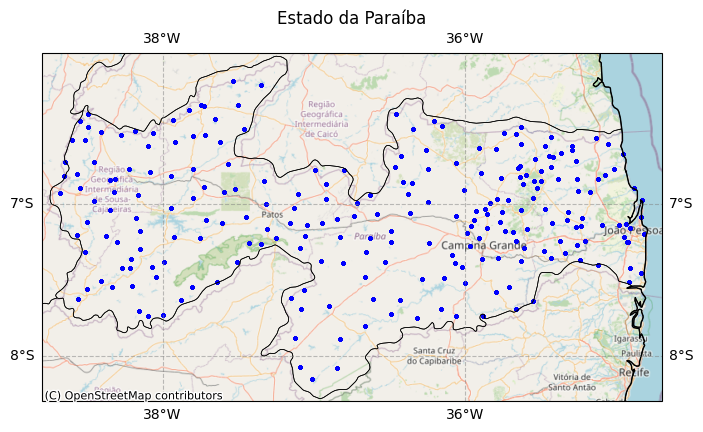

In [8]:
grafico_de_pontos(df_aesa_sum, 'lat', 'lon')

### 2.2.2. Geração de base de dados de precipitações diárias mensais máximas

In [ ]:
# # Salvando ou abrindo base de dados
# if generate_csv_max == True:

#     # Definindo base de dados
#     df_aesa_max = df_aesa.copy()

#     # Definindo colunas de interesse
#     colunas = [f'dia {i}' for i in range(1, 31)]

#     # Converter as colunas para float
#     for coluna in colunas:
#         df_aesa_max[coluna] = pd.to_numeric(df_aesa_max[coluna].str.replace(',', '.').str.strip(), errors='coerce')

#     # Criar a coluna com o maior valor por linha
#     df_aesa_max['Máximo'] = df_aesa_max[colunas].max(axis=1)

#     # Configurando colunas da base de dados a partir de base de dados original
#     df_aesa_max = df_aesa_max[['alt', 'bac', 'lat', 'lon', 'ano', 'mes', 'Máximo']].rename(
#         columns={
#             'Máximo': 'pr_local'
#         }
#     )

#     # Obtendo base de dados com serie temporal completa
#     df_expandido = complete_temporal_series(df_aesa, 'lat', 'lon', 'alt', 'bac', [i for i in range(1994, 2024)])

#     # Faz o merge com df_expandido como base
#     df_aesa_max = pd.merge(
#         df_expandido,
#         df_aesa_max,
#         on=['lat', 'lon', 'alt', 'bac', 'ano', 'mes'],
#         how='left'
#     )


#     # Interpolando linhas nulas
#     df_aesa_max = interpolacao_por_idw(df_aesa_max, 'alt', 'alt', 'lat', 'lon', 'ano', 'mes', 'pnt', 5)
    
#     # Interpolando linhas nulas de precipitação
#     df_aesa_max = interpolacao_por_idw(df_aesa_max, 'pr_local', 'pr_local', 'lat', 'lon', 'ano', 'mes', 'pnt', 5)

#     # Salva CSV
#     df_aesa_max.to_csv("../datas/interim/2.3.1_aesa_database_create/aesa_1994-2023_mon_max.csv")
    
# else:
    
#     # Abre CSV
#     df_aesa_max = pd.read_csv("../datas/interim/2.3.1_aesa_database_create/aesa_1994-2023_mon_max.csv") 

# # Informações da base de dados
# df_aesa_max.info()

In [10]:
# grafico_de_pontos(df_aesa_max, 'lat', 'lon')